In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

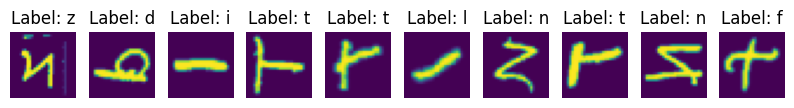

In [34]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
train_ds = datasets.EMNIST(root="./data", split="letters", train=True, download=True, transform=transform)
test_ds = datasets.EMNIST(root="./data", split="letters", train=False, download=True, transform=transform)


sample_indices_train = random.sample(range(len(train_ds)), 10)
sample_indices_test = random.sample(range(len(test_ds)), 10)
fig, axes = plt.subplots(1, len(sample_indices_train), figsize=(10, 2))
for idx, ax in zip(sample_indices_train, axes):
    image, label = train_ds[idx]
    ax.imshow(image.permute(1, 2, 0).squeeze())
    ax.set_title(f'Label: {train_ds.classes[label]}')
    ax.axis('off')
plt.show()

# for idx, ax in zip(sample_indices_test, axes):
#     image, label = test_ds[idx]
#     ax.imshow(image.permute(1, 2, 0).squeeze())
#     ax.set_title(f'Label: {train_ds.classes[label]}')
#     ax.axis('off')
# plt.show()



In [36]:
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [38]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 13 * 13, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 26),
    nn.Softmax(dim=1)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

In [39]:
def accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            labels -= 1
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100

In [40]:
def train(model, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            labels -= 1
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total * 100
        val_acc = accuracy(test_loader, model)
        print(
            f"Epoch {epoch + 1}: Train Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


train(model, train_loader, test_loader, epochs=10)

Epoch 1/10: 100%|██████████| 975/975 [00:31<00:00, 31.06it/s]


Epoch 1: Train Loss: 2.8241, Train Acc: 50.04%, Val Acc: 57.44%


Epoch 2/10: 100%|██████████| 975/975 [00:33<00:00, 28.74it/s]


Epoch 2: Train Loss: 2.7030, Train Acc: 62.10%, Val Acc: 67.63%


Epoch 3/10: 100%|██████████| 975/975 [00:33<00:00, 28.86it/s]


Epoch 3: Train Loss: 2.6017, Train Acc: 72.22%, Val Acc: 74.75%


Epoch 4/10: 100%|██████████| 975/975 [00:33<00:00, 29.18it/s]


Epoch 4: Train Loss: 2.5216, Train Acc: 80.30%, Val Acc: 82.07%


Epoch 5/10: 100%|██████████| 975/975 [00:33<00:00, 28.82it/s]


Epoch 5: Train Loss: 2.4924, Train Acc: 83.10%, Val Acc: 82.84%


Epoch 6/10: 100%|██████████| 975/975 [00:33<00:00, 28.98it/s]


Epoch 6: Train Loss: 2.4603, Train Acc: 86.36%, Val Acc: 86.44%


Epoch 7/10: 100%|██████████| 975/975 [00:33<00:00, 28.92it/s]


Epoch 7: Train Loss: 2.4440, Train Acc: 87.94%, Val Acc: 86.62%


Epoch 8/10: 100%|██████████| 975/975 [00:33<00:00, 28.86it/s]


Epoch 8: Train Loss: 2.4396, Train Acc: 88.37%, Val Acc: 87.02%


Epoch 9/10: 100%|██████████| 975/975 [00:33<00:00, 28.68it/s]


Epoch 9: Train Loss: 2.4334, Train Acc: 88.95%, Val Acc: 90.41%


Epoch 10/10: 100%|██████████| 975/975 [00:33<00:00, 28.77it/s]


Epoch 10: Train Loss: 2.3955, Train Acc: 92.82%, Val Acc: 91.08%


In [41]:
torch.save(model.state_dict(), "letter_recognition_model.pth")

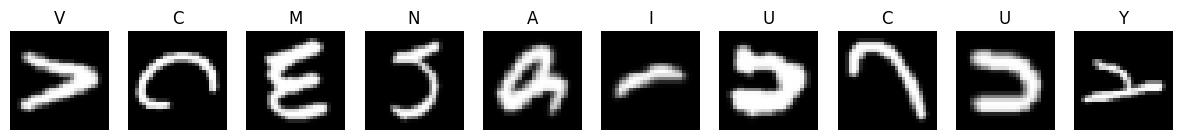

In [42]:
model.eval()
images, labels = next(iter(test_loader))
predictions = model(images).argmax(dim=1)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(chr(predictions[i].item() + ord('A')))
    ax.axis('off')
plt.show()